[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cadCAD-org/demos/blob/master/tutorials/robots_and_marbles/robot-marbles-part-3/robot-marbles-part-3.ipynb)

# cadCAD Tutorials: The Robot and the Marbles, part 3
In parts [1](../robot-marbles-part-1/robot-marbles-part-1.ipynb) and [2](../robot-marbles-part-2/robot-marbles-part-2.ipynb) we introduced the 'language' in which a system must be described in order for it to be interpretable by cadCAD and some of the basic concepts of the library:
* State Variables
* Timestep
* State Update Functions
* Partial State Update Blocks
* Simulation Configuration Parameters
* Policies

In this notebook we'll look at how subsystems within a system can operate in different frequencies. But first let's copy the base configuration with which we ended Part 2. Here's the description of that system:

__The robot and the marbles__  
* Picture a box (`box_A`) with ten marbles in it; an empty box (`box_B`) next to the first one; and __two__ robot arms capable of taking a marble from any one of the boxes and dropping it into the other one. 
* The robots are programmed to take one marble at a time from the box containing the largest number of marbles and drop it in the other box. They repeat that process until the boxes contain an equal number of marbles.
* The robots act simultaneously; in other words, they assess the state of the system at the exact same time, and decide what their action will be based on that information.

In [1]:
%%capture
# Only run this cell if you need to install the libraries
# If running in google colab, this is needed.

!pip install cadcad matplotlib pandas numpy

In [2]:
# Import dependancies

# Data processing and plotting libraries
import pandas as pd
import numpy as np
from random import normalvariate
import matplotlib.pyplot as plt

# cadCAD specific libraries
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD.engine import ExecutionContext, Executor

In [3]:
def p_robot_arm(params, substep, state_history, previous_state):
    
    # Parameters & variables
    box_a = previous_state['box_A']
    box_b = previous_state['box_B']
    
    # Logic
    if box_b > box_a:
        b_to_a = 1
    elif box_b < box_a:
        b_to_a = -1
    else:
        b_to_a = 0
    
    # Output
    return({'add_to_A': b_to_a, 'add_to_B': -b_to_a})

In [4]:
def s_box_A(params, substep, state_history,  previous_state, policy_input):
    # Parameters & variables
    box_A_current = previous_state['box_A']
    box_A_change = policy_input['add_to_A']
   
    # Logic
    box_A_new = box_A_current + box_A_change
    
    # Output
    return ('box_A', box_A_new)
    
def s_box_B(params, substep, state_history,  previous_state, policy_input):
    # Parameters & variables
    box_B_current = previous_state['box_B']
    box_B_change = policy_input['add_to_B']

    # Logic
    box_B_new = box_B_current + box_B_change
    
    # Output
    return ('box_B', box_B_new)

In [5]:
partial_state_update_blocks = [
    {
        'policies': {
            'robot_arm_1': p_robot_arm,
            'robot_arm_2': p_robot_arm

        },
        'variables': {
            'box_A': s_box_A,
            'box_B': s_box_B
        }
    }
]

In [6]:
MONTE_CARLO_RUNS = 1
SIMULATION_TIMESTEPS = 10

sim_config = config_sim(
    {
        'N': MONTE_CARLO_RUNS,
        'T': range(SIMULATION_TIMESTEPS),
        #'M': {} # This will be explained in later tutorials
    }
)

In [7]:
initial_state = {
    'box_A': 10, # box_A starts out with 10 marbles in it
    'box_B': 0 # box_B starts out empty
}

In [8]:
from cadCAD import configs
del configs[:]

experiment = Experiment()

experiment.append_configs(
    sim_configs=sim_config,
    initial_state=initial_state,
    partial_state_update_blocks=partial_state_update_blocks,
)

exec_context = ExecutionContext()
run = Executor(exec_context=exec_context, configs=configs)

(system_events, tensor_field, sessions) = run.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (10, 1, 1, 2)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 0.02s


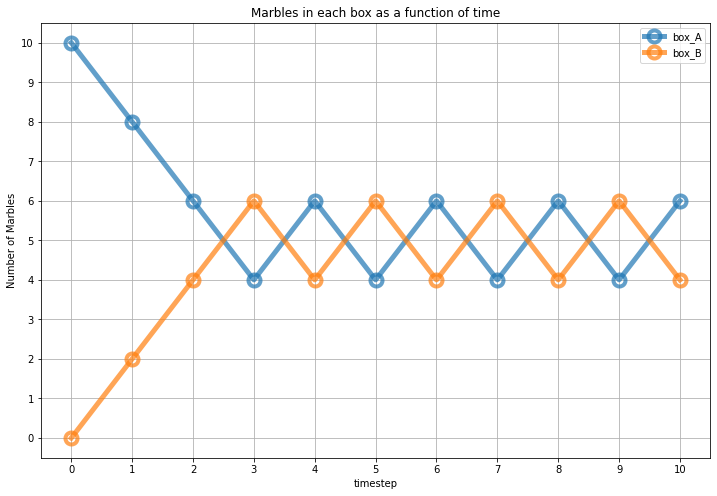

In [9]:
df = pd.DataFrame(system_events)
# Create figure
fig = df.plot(x='timestep', y=['box_A','box_B'], marker='o', markersize=12,
                markeredgewidth=4, alpha=0.7, markerfacecolor='black',
                linewidth=5, figsize=(12,8),  title="Marbles in each box as a function of time", 
                ylabel='Number of Marbles', grid=True, fillstyle='none',  
                xticks=list(df['timestep'].drop_duplicates()),
                yticks=list(range(1+(df['box_A']+df['box_B']).max())));

# Asynchronous Subsystems
We have defined that the robots operate simultaneously on the boxes of marbles. But it is often the case that agents within a system operate asynchronously, each having their own operation frequencies or conditions.

Suppose that instead of acting simultaneously, the robots in our examples operated in the following manner:
* Robot 1: acts once every 2 timesteps
* Robot 2: acts once every 3 timesteps

One way to simulate the system with this change is to introduce a check of the current timestep before the robots act, with the definition of separate policy functions for each robot arm.

In [17]:
robots_periods = [2,3] # Robot 1 acts once every 2 timesteps; Robot 2 acts once every 3 timesteps

def get_current_timestep(cur_substep, previous_state):
    if cur_substep == 1:
        return previous_state['timestep']+1
    return previous_state['timestep']

def robot_arm_1(params, substep, state_history, previous_state):
    _robotId = 1
    if get_current_timestep(substep, previous_state)%robots_periods[_robotId-1]==0: # on timesteps that are multiple of 2, Robot 1 acts
        return p_robot_arm(params, substep, state_history, previous_state)
    else:
        return({'add_to_A': 0, 'add_to_B': 0}) # for all other timesteps, Robot 1 doesn't interfere with the system

def robot_arm_2(params, substep, state_history, previous_state):
    _robotId = 2
    if get_current_timestep(substep, previous_state)%robots_periods[_robotId-1]==0: # on timesteps that are multiple of 3, Robot 2 acts
        return p_robot_arm(params, substep, state_history, previous_state)
    else:
        return({'add_to_A': 0, 'add_to_B': 0}) # for all other timesteps, Robot 1 doesn't interfere with the system

In the Partial State Update Blocks, the user specifies if state update functions will be run in series or in parallel and the policy functions that will be evaluated in that block

In [19]:
partial_state_update_blocks = [
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'robot_arm_1': robot_arm_1,
            'robot_arm_2': robot_arm_2
        },
        'variables': { # The following state variables will be updated simultaneously
            'box_A': s_box_A,
            'box_B': s_box_B
        }
    }
]

In [20]:
from cadCAD import configs
del configs[:]

experiment = Experiment()

experiment.append_configs(
    sim_configs=sim_config,
    initial_state=initial_state,
    partial_state_update_blocks=partial_state_update_blocks,
)

exec_context = ExecutionContext()
run = Executor(exec_context=exec_context, configs=configs)

(system_events, tensor_field, sessions) = run.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (10, 1, 1, 2)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 0.01s


In [ ]:
simulation_result.plot('timestep', ['box_A', 'box_B'], 
        grid=True, 
        xticks=list(simulation_result['timestep'].drop_duplicates()), 
        yticks=list(range(1+max(simulation_result['box_A'].max(),simulation_result['box_B'].max()))),
        colormap = 'RdYlGn'
       )

Let's take a step-by-step look at what the simulation tells us:
* Timestep 1: the number of marbles in the boxes does not change, as none of the robots act
* Timestep 2: Robot 1 acts, Robot 2 doesn't; resulting in one marble being moved from box A to box B
* Timestep 3: Robot 2 acts, Robot 1 doesn't; resulting in one marble being moved from box A to box B
* Timestep 4: Robot 1 acts, Robot 2 doesn't; resulting in one marble being moved from box A to box B
* Timestep 5: the number of marbles in the boxes does not change, as none of the robots act
* Timestep 6: Robots 1 __and__ 2 act, as 6 is a multiple of 2 __and__ 3; resulting in two marbles being moved from box A to box B and an equilibrium being reached.